In [33]:
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [ ]:
train_csv_paths = list(glob(os.path.join('.', 'train_*.csv')))
valid_csv_paths = list(glob(os.path.join('.', 'valid_*.csv')))
assert len(train_csv_paths) > 0

In [ ]:
df = pd.read_csv(train_csv_paths[0])

In [ ]:
new_columns = {col: col.replace('validation__', '') for col in df.columns if col.startswith('validation__')}
df = df.rename(columns=new_columns)

In [ ]:
unweighted_sample_cols = [
    str(col) for col in df.columns if 'unweigted_sample_loss' in col
]

In [ ]:
epochs = sorted(list(set(df.epoch_id)))
epochs

In [ ]:
unweighted_losses = []
for i in epochs:
    loss = df.loc[df.epoch_id == i].iloc[:, df.columns.isin(unweighted_sample_cols)].sum(axis=1).mean()
    unweighted_losses.append(loss)
plt.plot(unweighted_losses)

In [ ]:
cols = list(df.columns)
rotation_cols = list(col for col in cols if '_rotation_' in col and 'sample_loss' in col)
position_cols = list(col for col in cols if '_position_' in col and 'sample_loss' in col)
fig = plt.figure()
mean_loss = df[rotation_cols + position_cols + ['epoch_id']].groupby('epoch_id').mean()
ax = mean_loss.plot(ylabel='cross_entropy_loss')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
per_task_loss = df[rotation_cols + position_cols + ['task']].groupby('task').sum().sum(axis=1).sort_values()
per_task_loss / per_task_loss.min()

Learning Rate

In [ ]:
import math 
from playground.typing import TrainParam, DatasetParam

def get_lr_param():
    return {
        "warmup_end_at_iters": 7000,
        "flatten_end_at_iters": 240000,
        "lr_decay_end_at_iters": 960000,
        "learning_rate": 1e-5,
        "min_lr": 1e-7, 
    }


def get_optimizer_param():
    return {
        "clip_norm": 1.0,
        "inital_lr": get_lr_param()["learning_rate"],
        "optimizer_name": "AdamW",
        "weight_decay": 0.0
    }

def get_dataset_param():
    return  {
        "data_pct_usage": 1.0,
        "total_data_size_per_task": 40000,
        "validation_pct": 0.00,
        "source": "s3://vima",
        "tasks": [
            "follow_order",
            "manipulate_old_neighbor",
            "novel_adj",
            "novel_noun",
            "pick_in_order_then_restore",
            "rearrange_then_restore",
            "rearrange",
            "rotate",
            "same_profile",
            "scene_understanding",
            "simple_manipulation",
            "sweep_without_exceeding",
            "twist",
        ]
    }

def get_train_param():
    return {
        "model_size": "2M",
        "total_epoch": 50,
        "local_batch_size": 128,
        "distributed": False,
    }
def get_lr(it: int) -> float:
    lr_param = get_lr_param()
    warmup_iters = lr_param["warmup_end_at_iters"]
    flatten_iters = lr_param["flatten_end_at_iters"]
    learning_rate = lr_param["learning_rate"]
    lr_decay_iters = lr_param["lr_decay_end_at_iters"]
    min_lr = lr_param["min_lr"]
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if warmup_iters <= it < flatten_iters:
        return learning_rate
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - flatten_iters) / (lr_decay_iters - flatten_iters)
    assert 0 <= decay_ratio <= 1, f"{decay_ratio = }, {it = }"
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)


def get_batch_per_epoch(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        is_train: bool = True
    ):
    if is_train:
        scaling = 1.0
    else:
        scaling = dataset_param["validation_pct"]
    epoch_size = ( 
        int(
            dataset_param["total_data_size_per_task"] 
            * scaling 
            * len(dataset_param["tasks"]
        ) 
        * dataset_param["data_pct_usage"]) 
    )
    batch_size = (
        train_param["local_batch_size"] 
            if train_param["distributed"] is False 
            else train_param["local_batch_size"] * 1
    )
    if epoch_size % batch_size != 0:
        return epoch_size // batch_size + 1
    return epoch_size // batch_size

def get_total_batch_count(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int,
        is_train: bool = True
    ) -> int:
    batch_count_per_epoch = get_batch_per_epoch(dataset_param, train_param, is_train)
    current_total_batch_count = batch_id + epoch_id * batch_count_per_epoch
    return current_total_batch_count

def measure_lr(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int
    ):
    current_total_batch_count = get_total_batch_count(
        dataset_param, 
        train_param, 
        batch_id, 
        epoch_id, 
        is_train=True
    )
    return get_lr(current_total_batch_count)

In [ ]:
def get_lrs():
    lrs = []
    for epoch_id in range(get_train_param()["total_epoch"]):
        for batch_id in range(
            get_batch_per_epoch(
                get_dataset_param(),
                get_train_param(),
            )
        ):
            lrs.append(
                measure_lr(
                    get_dataset_param(),
                    get_train_param(),
                    batch_id,
                    epoch_id
                )
            )
    return lrs

In [ ]:
lrs = get_lrs()
print(len(lrs))
_ = plt.plot(lrs)

Eval Result

In [18]:
df = pd.read_csv('eval_2024-05-29_magic-forest-690_51_run.csv')

In [27]:
def calc_success_rate(df):
    task_ids = {
        "visual_manipulation": "01",
        "scene_understanding": "02",
        "rotate": "03",
        "rearrange": "04",
        "rearrange_then_restore": "05",
        "novel_adj": "06",
        "novel_noun": "07",
        "novel_adj_and_noun": "08",
        "twist": "09",
        "follow_motion": "10",
        "follow_order": "11",
        "sweep_without_exceeding": "12",
        "sweep_without_touching": "13",
        "same_texture": "14",
        "same_shape": "15",
        "manipulate_old_neighbor": "16",
        "pick_in_order_then_restore": "17"
    }
    return {
        task_ids[group.iloc[0]['task']]: round(float(group[['sucess']].mean().iloc[0] * 100), 1)
            for _, group in df.groupby('task')
    }

eval_success_rates = calc_success_rate(df)

In [28]:
sorted(list(eval_success_rates.items()))

[('01', 98.0),
 ('02', 73.0),
 ('03', 96.0),
 ('04', 96.0),
 ('05', 49.0),
 ('06', 47.0),
 ('07', 73.0),
 ('09', 16.0),
 ('11', 71.0),
 ('12', 94.0),
 ('15', 84.0),
 ('16', 73.0),
 ('17', 4.0)]

In [21]:
sum(eval_success_rates.values()) / len(eval_success_rates)

67.23076923076923

In [58]:
all_results = glob(os.path.join('remote_eval', 'result', '*.csv'))
all_results = {
    epoch: path for epoch, path in 
    zip(
        map(
            lambda x: int(os.path.basename(x).split('_')[3]),
            all_results
        ),
        all_results
    ) 
}
def parse_eval_csv(payload):
    epoch, path = payload
    return epoch, calc_success_rate(pd.read_csv(path))
success_rate_trace = list(map(
    parse_eval_csv,
    list(sorted(all_results.items()))
))

In [60]:
def extract_single_success(task_id: str, trace: List[Tuple[int, Dict[str, float]]]):
    return ( 
        list(x[0] for x in trace),
        list(x[1][task_id] for x in trace)
    )
        
def extract_avg_success(trace: List[Tuple[int, Dict[str, float]]]):
    return ( 
        list(x[0] for x in trace),
        list(sum(x[1].values()) / len(x[1]) for x in trace)
    )

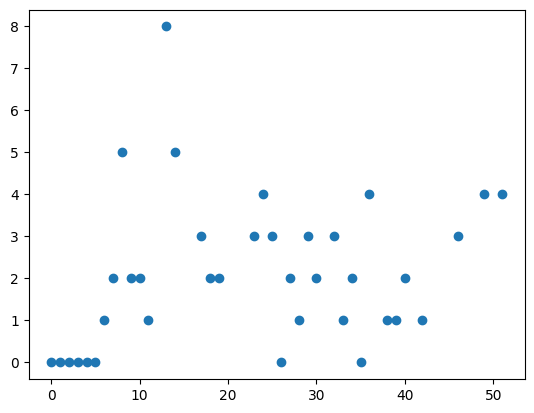

In [56]:
x, y = extract_single_success("17", success_rate_trace)
plt.scatter(x, y)

In [63]:
ys[-5:]

[68.0, 67.23076923076923, 67.84615384615384]

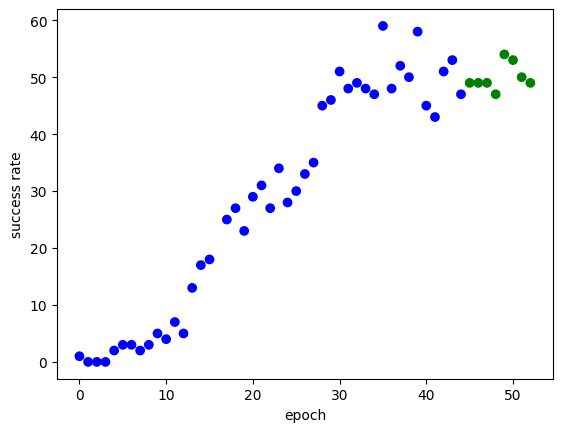

In [74]:
xs, ys = extract_single_success("05", success_rate_trace)
plt.xlabel('epoch')
plt.ylabel('success rate')
decide = lambda i: 'b' if i < 45 else 'g'
colors = [decide(x) for x in xs]
plt.scatter(xs, ys, color=colors)

Evalution

In [ ]:
import pandas as pd
import glob


mode = 'train'
file_pattern = f'logs\\{mode}_*.csv'
csv_files = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in csv_files]
solution_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
position_loss_cols = [col for col in loss_cols if 'position' in col]
rotation_loss_cols = [col for col in loss_cols if 'rotation' in col]

In [ ]:
rename = {
    old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
        for old_col_name in loss_cols
}
df[loss_cols].rename(columns=rename).describe()

In [ ]:
for task_name, task_df in df[position_loss_cols + ['task']].groupby('task'):
    rename = {
        old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
            for old_col_name in position_loss_cols
    }
    print(task_name)
    print(task_df[position_loss_cols].rename(columns=rename).describe())
    print("=============")

In [ ]:
df['sum_loss'] = df[position_loss_cols].sum(axis=1)
df.groupby('task')['sum_loss'].describe().T.columns

In [1]:
import pandas as pd
import glob
import os
from typing import List, Literal, Callable

In [2]:

mode = 'train'
i = 28
    
file_pattern = f'logs/{mode}_{i}_*.csv'
csv_files = glob.glob(file_pattern)
dataframes = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dataframes, ignore_index=True)

In [3]:
loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
position_loss_cols = [col for col in loss_cols if 'position' in col]
rotation_loss_cols = [col for col in loss_cols if 'rotation' in col]

In [4]:
rename = {
    old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
        for old_col_name in loss_cols
}
df[loss_cols].rename(columns=rename).describe().columns

Index(['pose0_position_0', 'pose0_position_1', 'pose1_position_0',
       'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
       'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
       'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'],
      dtype='object')

In [5]:
exps = set(
    [
        str(os.path.basename(file_path))
        .split('.')[0]
        .split('_')[2] 
            for file_path in glob.glob('logs/*.csv')
    ]
)

In [ ]:
def get_trace_paths(
        exp_id: str, 
        mode: str
    ):
    return [
        exp
            for exp in sorted(
                glob.glob(f'logs/{mode}_*_{exp_id}.csv'),
                key = lambda x: int(x.split('_')[1])
            )
    ]

def trace_epoch(
        exp_id: str, 
        mode: str = 'train'
    ) -> List[pd.DataFrame]:
    return [
        pd.read_csv(exp)
            for exp in 
                get_trace_paths(exp_id, mode)
    ]

def trace_ddp(exp_ids: List[str], epoch: int, mode: str = 'train') -> pd.DataFrame:
    exp_paths = [
        os.path.join('logs', f'{mode}_{epoch}_{exp_id}.csv') for exp_id in exp_ids
    ]
    exp_paths = filter(lambda x: os.path.exists(x), exp_paths)
    dataframes = [
        pd.read_csv(exp_path) for exp_path in exp_paths
    ]
    df = pd.concat(dataframes, ignore_index=True)
    return df


In [ ]:
dfs = [
    trace_ddp(exps, i, 'train') for i in range(30)
]

In [8]:
Aggregator = Literal['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
Transform = Callable[[pd.DataFrame], pd.DataFrame]
def measure(
        df: pd.DataFrame, 
        transform: Transform, 
        attr: str, 
        aggr: Aggregator
    ) -> float:
    df = transform(df)
    describe = df.describe()
    if attr not in describe.columns:
        describe = describe.T
    return describe[attr][aggr]
    

In [9]:
attributes = [
    'pose0_position_0', 'pose0_position_1', 'pose1_position_0',
    'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
    'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
    'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'
]
tasks = [
    'follow_order', 'manipulate_old_neighbor', 'novel_adj', 'novel_noun',
    'pick_in_order_then_restore', 'rearrange', 'rearrange_then_restore',
    'rotate', 'same_profile', 'scene_understanding', 'simple_manipulation',
    'sweep_without_exceeding', 'twist'
]

In [10]:
def per_attr_transform(df: pd.DataFrame) -> pd.DataFrame:
    loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
    rename = {
        old_col_name: old_col_name.replace("unweigted_sample_loss__", "") 
            for old_col_name in loss_cols
    }
    return df[loss_cols].rename(columns=rename)

In [ ]:
measure(solution_df, per_attr_transform, 'pose0_position_0', 'mean')

In [11]:
for attr in attributes:
    print(attr, measure(df, per_attr_transform, attr, 'mean'))

pose0_position_0 2.5164652174368567
pose0_position_1 2.683360951411237
pose1_position_0 2.3695924351840696
pose1_position_1 2.5140032555548077
pose0_rotation_0 4.584972169451563e-12
pose0_rotation_1 3.438729041686901e-12
pose0_rotation_2 1.0316183831968408e-11
pose0_rotation_3 7.335953547191401e-12
pose1_rotation_0 7.106705815282601e-12
pose1_rotation_1 3.4387289460369175e-12
pose1_rotation_2 0.1164562022158738
pose1_rotation_3 0.11637165202951653


In [12]:
def per_task_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    loss_cols = [col for col in df.columns if 'unweigted_sample_loss' in col]
    df['sum_loss'] = df[loss_cols].sum(axis=1)
    return df.groupby('task')['sum_loss']

In [13]:
for task in tasks:
    print(task, measure(
        df, 
        per_task_transform, 
        task, 
        'mean'))

follow_order 9.0810283495754
manipulate_old_neighbor 9.63858021145165
novel_adj 11.057612526613473
novel_noun 10.83901124842763
pick_in_order_then_restore 10.316806644153594
rearrange 10.580935571166872
rearrange_then_restore 11.254499254134297
rotate 11.185289274151783
same_profile 10.296298843207955
scene_understanding 10.97366121263504
simple_manipulation 10.471731265977025
sweep_without_exceeding 3.835812006748312
twist 14.579979872048552


In [ ]:

for task in attributes:
    print(task, measure(
        solution_df.loc[
            (solution_df['unweigted_sample_loss__pose0_position_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_position_1'] < 4.6) &
            (solution_df['unweigted_sample_loss__pose1_position_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_position_1'] < 4.6) &
            (solution_df['unweigted_sample_loss__pose0_rotation_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_1'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_2'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose0_rotation_3'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_0'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_1'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_2'] < 3.9) &
            (solution_df['unweigted_sample_loss__pose1_rotation_3'] < 3.9) 
        ], 
        per_attr_transform, 
        task, 
        'mean'))

In [ ]:
measure(solution_df, per_task_transform, 'follow_order', 'mean')

In [ ]:
follow_order = [measure(df, per_task_transform, 'follow_order', 'mean') for df in dfs]
follow_order

### Trace Accu

In [27]:
import pandas as pd
from functools import partial

In [35]:
df = pd.read_csv('eval_2024-05-23_rare-valley-665_28_2024-05-25.csv')

In [36]:

def per_trace_accu(row: pd.Series, col: str, threshold: float) -> float:
    correct_trace: List[int] = []
    for t_step in range(10):
        ground_truth = row.loc[f'action_trace__{t_step}__oracle_action__{col}']
        prediction = row.loc[f'action_trace__{t_step}__policy_action__{col}']
        if pd.isna(ground_truth) and pd.isna(prediction):
            break
        if pd.isna(ground_truth) or pd.isna(prediction):
            correct_trace.append(0)
            continue
        
        correct_trace.append(int(abs(ground_truth - prediction) <= threshold))
    if len(correct_trace) < 0:
        return 0
    return sum(correct_trace) / len(correct_trace)

        

In [37]:
attributes = [
    'pose0_position_0', 'pose0_position_1', 'pose1_position_0',
    'pose1_position_1', 'pose0_rotation_0', 'pose0_rotation_1',
    'pose0_rotation_2', 'pose0_rotation_3', 'pose1_rotation_0',
    'pose1_rotation_1', 'pose1_rotation_2', 'pose1_rotation_3'
]

In [38]:
accus = {
    attribute: df.apply(partial(per_trace_accu, col=attribute, threshold=0), axis=1).mean()
    for attribute in attributes 
}

In [39]:
position_accus = [accus[key] for key in accus if 'position' in key]
rotation_accus = [accus[key] for key in accus if 'rotation' in key]
sum(position_accus) / len(position_accus),  sum(rotation_accus) / len(rotation_accus),

(0.36526449938949934, 0.6857811736874238)

In [32]:
position_accus = [accus[key] for key in accus if 'position' in key]
rotation_accus = [accus[key] for key in accus if 'rotation' in key]
sum(position_accus) / len(position_accus),  sum(rotation_accus) / len(rotation_accus),

(0.383246336996337, 0.682220695970696)

In [40]:
for attribute in attributes:
    print(attribute, df.apply(partial(per_trace_accu, col=attribute, threshold=2), axis=1).mean())

pose0_position_0 0.7446236263736263
pose0_position_1 0.6785747863247863
pose1_position_0 0.7944786324786326
pose1_position_1 0.6783711843711844
pose0_rotation_0 0.9973076923076923
pose0_rotation_1 0.9973076923076923
pose0_rotation_2 0.9973076923076923
pose0_rotation_3 0.9973076923076923
pose1_rotation_0 0.9973076923076923
pose1_rotation_1 0.9973076923076923
pose1_rotation_2 0.449815934065934
pose1_rotation_3 0.30845482295482296


In [34]:
for attribute in attributes:
    print(attribute, df.apply(partial(per_trace_accu, col=attribute, threshold=2), axis=1).mean())

pose0_position_0 0.80595115995116
pose0_position_1 0.7393510378510378
pose1_position_0 0.8283333333333333
pose1_position_1 0.7031275946275946
pose0_rotation_0 0.9969230769230769
pose0_rotation_1 0.9969230769230769
pose0_rotation_2 0.9969230769230769
pose0_rotation_3 0.9969230769230769
pose1_rotation_0 0.9969230769230769
pose1_rotation_1 0.9969230769230769
pose1_rotation_2 0.4325054945054945
pose1_rotation_3 0.23856043956043957
